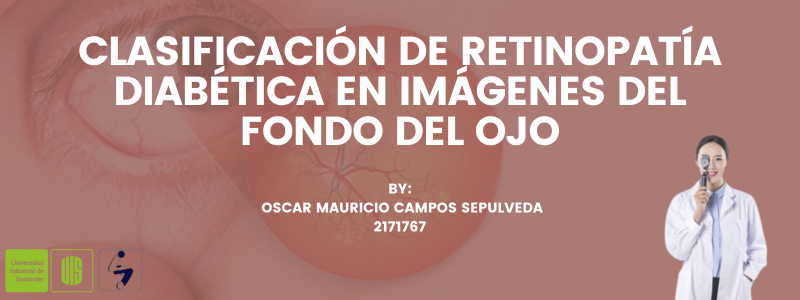

> La retinopatía diabética (RD) es una complicación ocular causada por daños en los vasos sanguíneos de la retina debido a niveles elevados de azúcar en la sangre, común en personas con diabetes. Es considerada una de las principales causas de ceguera en el mundo, lo que resalta la importancia de su diagnóstico temprano para prevenir o minimizar el daño visual.

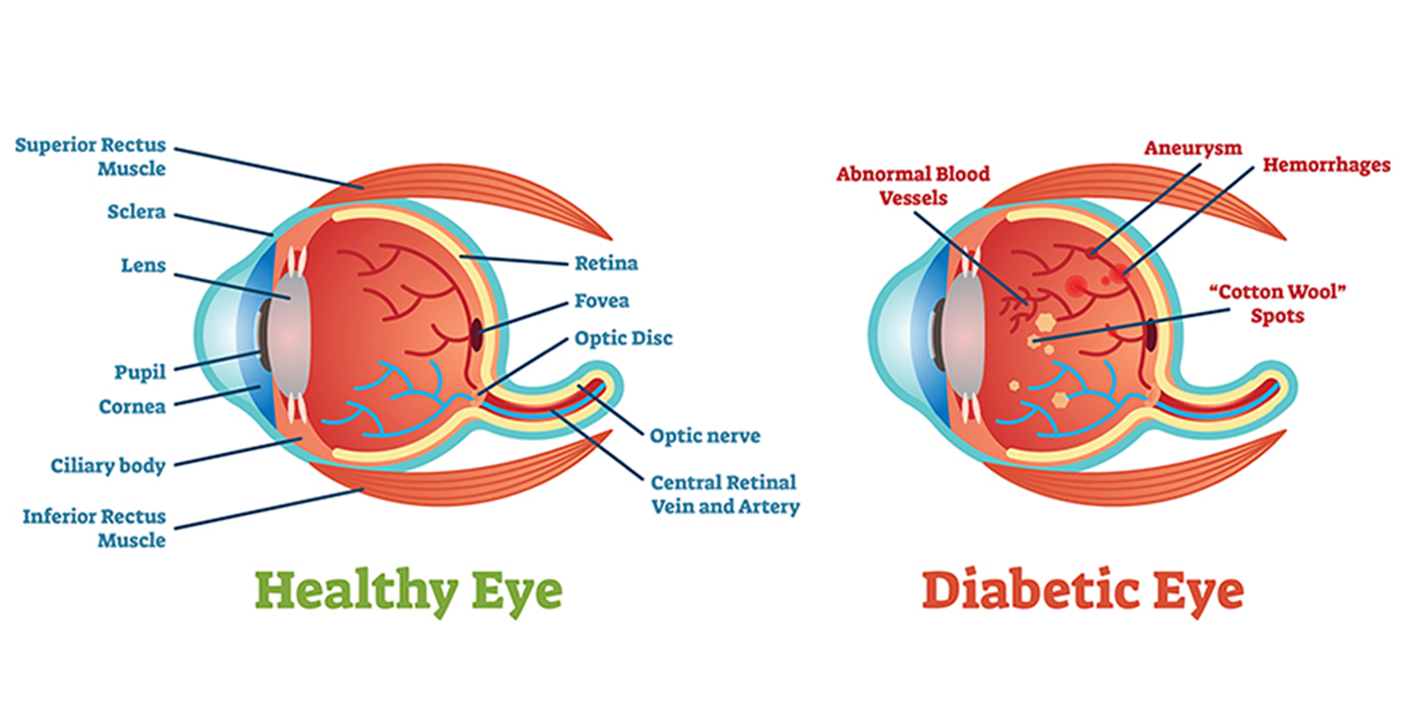
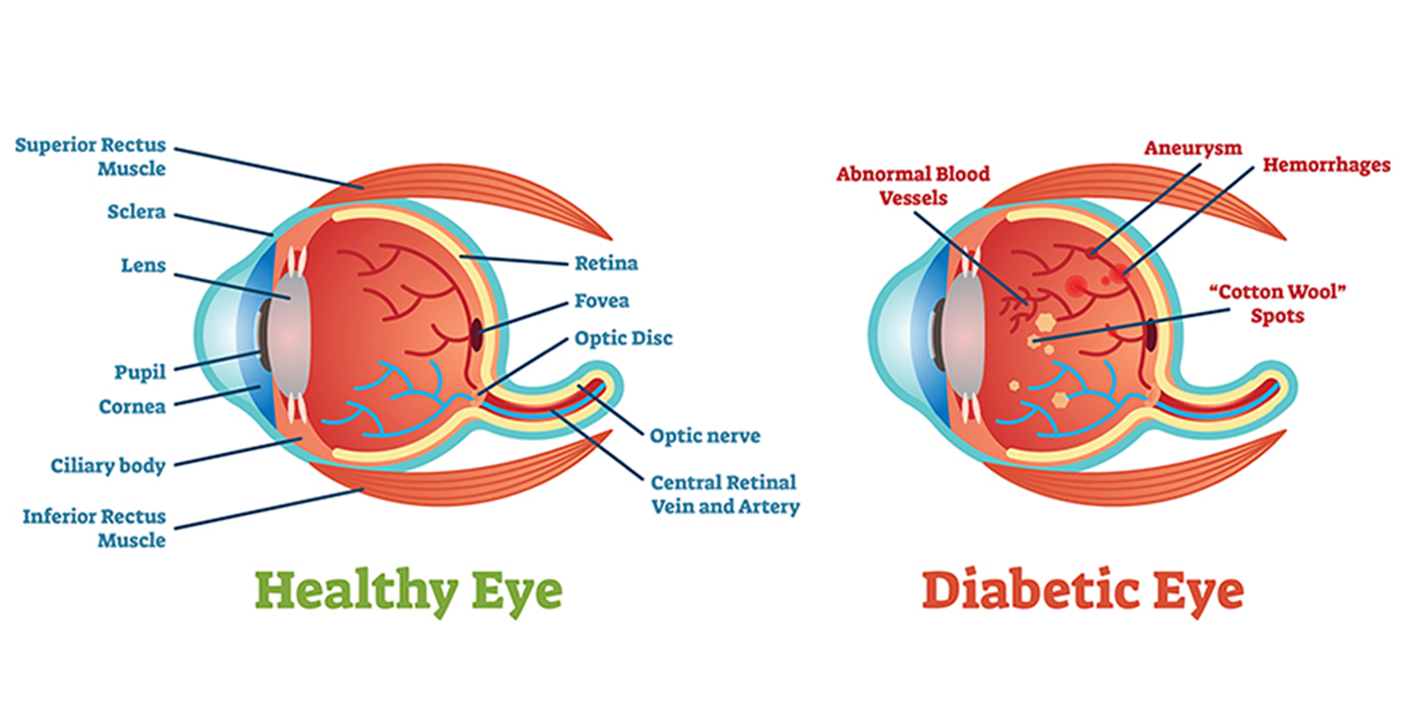
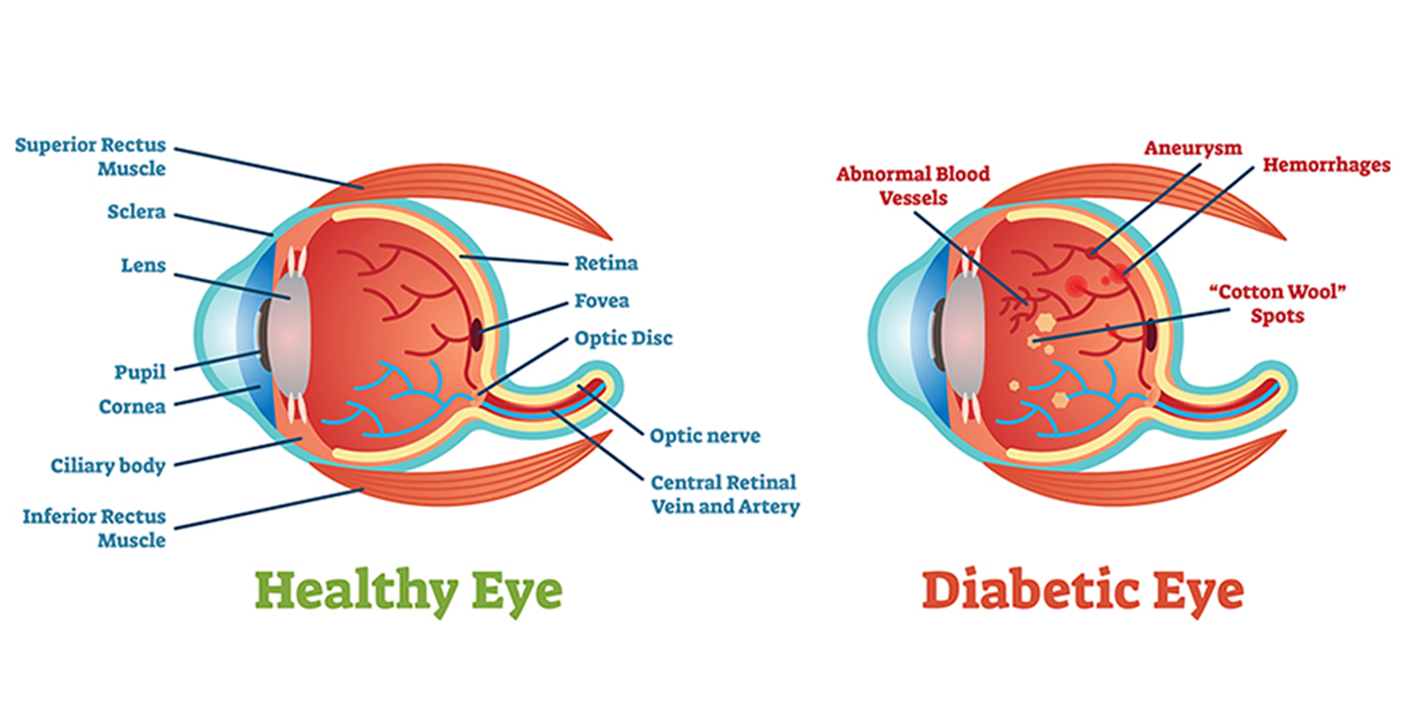
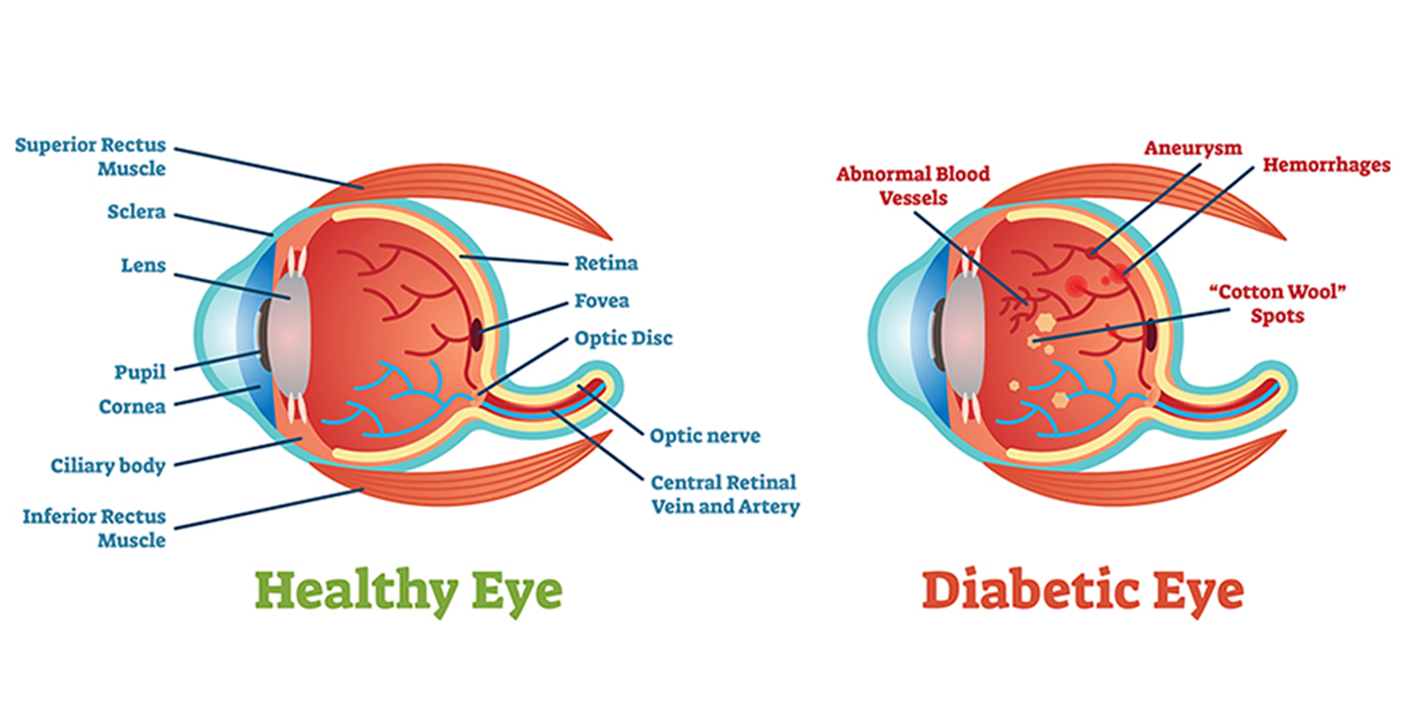
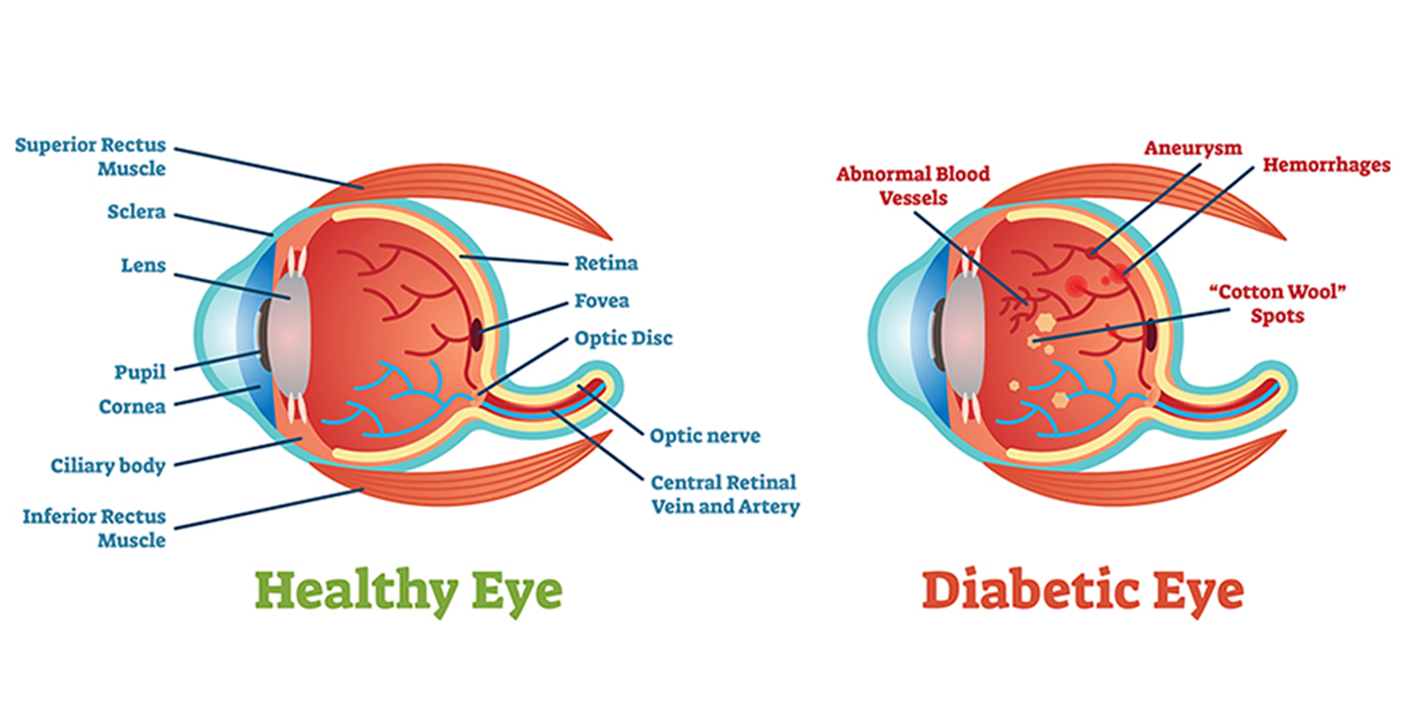
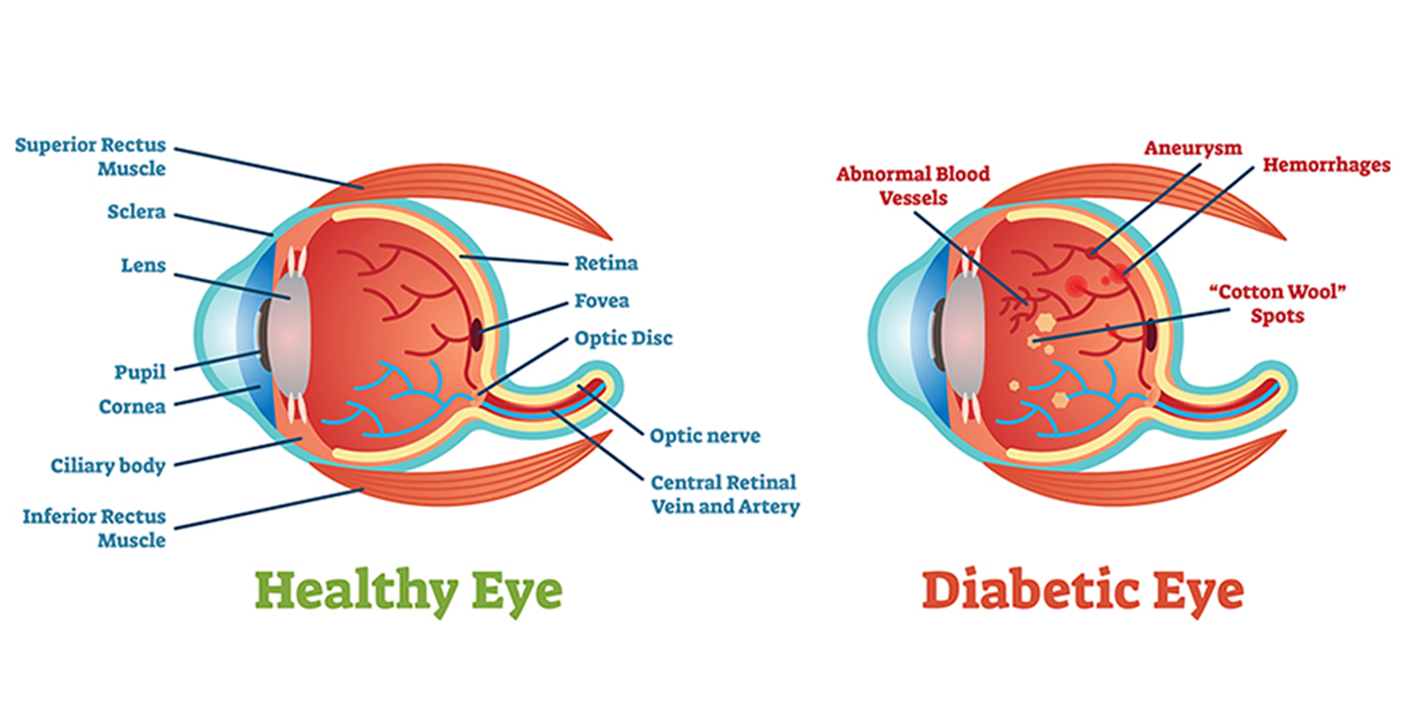

> Es posible que no tengas síntomas en las etapas iniciales de la retinopatía diabética. A medida que la afección progresa, los síntomas de la retinopatía diabética pueden incluir:

> * Manchas o hilos oscuros flotando en tu visión (flotadores)
> * Visión borrosa
> * Cambios fluctuantes en la visión
> * Dificultad para distinguir colores
> * Áreas oscuras o vacías en tu campo visual
> * Pérdida de visión

## LIBRERIAS

In [1]:
import numpy as np
import pandas as pd 
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")


## DATOS

In [2]:
# Verificar la versión de TensorFlow
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.16.1


In [3]:
input_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        input_files.append(file_path)

# Verificar el contenido 
print("Archivos encontrados:", len(input_files))

Archivos encontrados: 57091


In [4]:
train_dir = '/kaggle/input/dataset/dataset/train'
test_dir = '/kaggle/input/dataset/dataset/test'

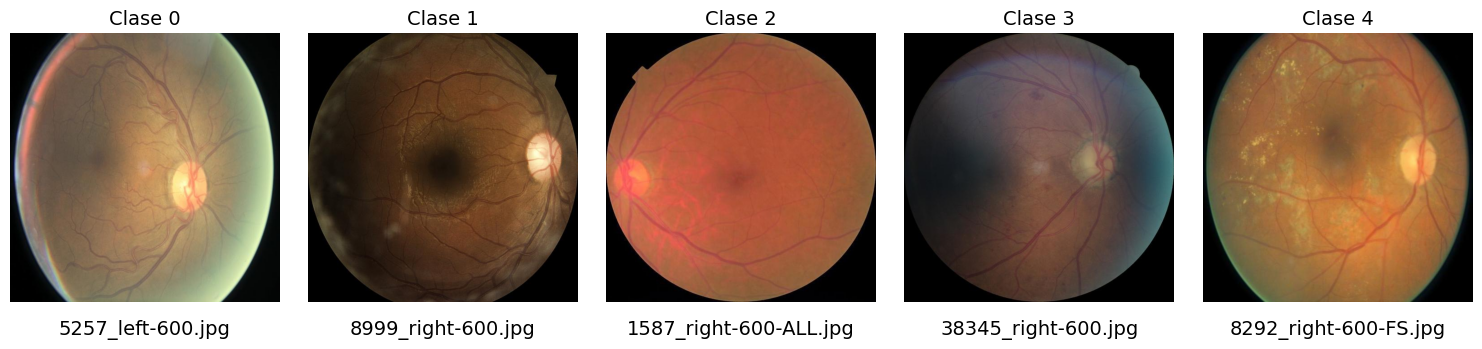

In [5]:
classes = ['0', '1', '2', '3', '4']
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    
    image_files = os.listdir(class_dir)
    image_file = random.choice(image_files)
    image_path = os.path.join(class_dir, image_file)

    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f'Clase {class_name}', fontsize=14)
    axes[i].axis('off')
    # Añadir el nombre del archivo debajo de la imagen
    axes[i].text(0.5, -0.1, image_file, ha='center', va='center', transform=axes[i].transAxes, fontsize=14)

plt.tight_layout()
plt.show()

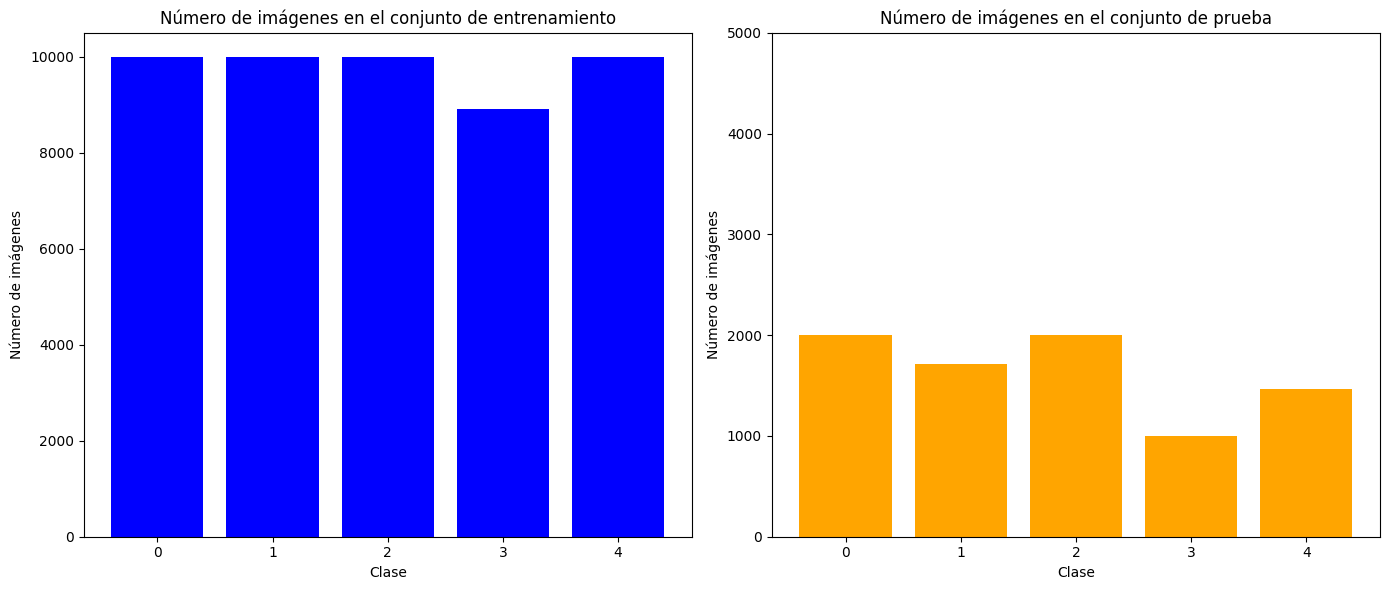

Número de imágenes en el conjunto de entrenamiento por clase:
{0: 10000, 1: 10000, 2: 10000, 3: 8914, 4: 10000}
Número de imágenes en el conjunto de validación por clase:
{0: 2000, 1: 1709, 2: 2000, 3: 1000, 4: 1468}


In [6]:
def count_images(base_dir):
    counts = {}
    for label in range(5):  
        folder_path = os.path.join(base_dir, str(label))
        if os.path.exists(folder_path):
            num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            counts[label] = num_images
        else:
            counts[label] = 0
    return counts

# Contar imágenes en los conjuntos de entrenamiento y prueba
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

# Graficar la distribución de imágenes
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Graficar el conjunto de entrenamiento
ax[0].bar(train_counts.keys(), train_counts.values(), color='blue')
ax[0].set_title('Número de imágenes en el conjunto de entrenamiento')
ax[0].set_xlabel('Clase')
ax[0].set_ylabel('Número de imágenes')

# Graficar el conjunto de prueba
ax[1].bar(test_counts.keys(), test_counts.values(), color='orange')
ax[1].set_title('Número de imágenes en el conjunto de prueba')
ax[1].set_xlabel('Clase')
ax[1].set_ylabel('Número de imágenes')
ax[1].set_ylim(0, 5000)

plt.tight_layout()
plt.show()

print("Número de imágenes en el conjunto de entrenamiento por clase:")
print(train_counts)

print("Número de imágenes en el conjunto de validación por clase:")
print(test_counts)

## GENERADORES 

In [7]:
#Crear generador para el conjunto de entrenamiento 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Crear generador para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

# Generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'  # Utiliza esta parte para el entrenamiento
)

# Generador para la validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'  # Utiliza esta parte para la validación
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 39132 images belonging to 5 classes.
Found 9782 images belonging to 5 classes.
Found 8177 images belonging to 5 classes.


## MODELO 

> Google presentó un artículo acompañado del código fuente de EfficientNet, una red neuronal convolucional (CNN) de diseño vanguardista que ha establecido nuevos estándares en precisión y eficiencia computacional. Esta mejora no fue marginal, ya que logró un aumento de precisión de hasta un 6 %, además de ser entre 5 y 10 veces más eficiente que la mayoría de las CNN existentes.

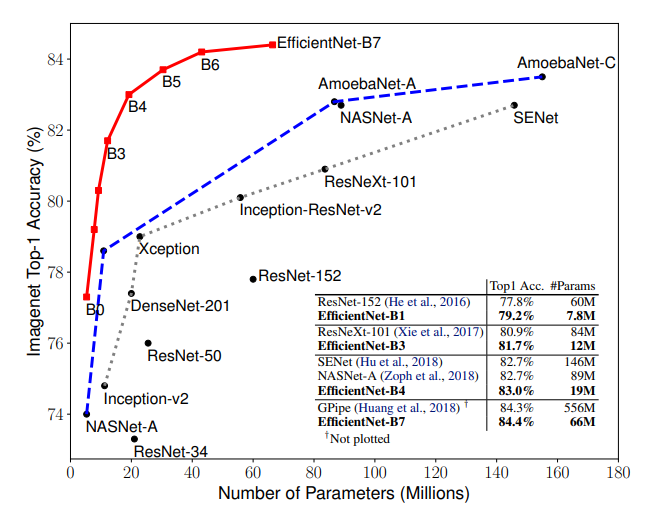
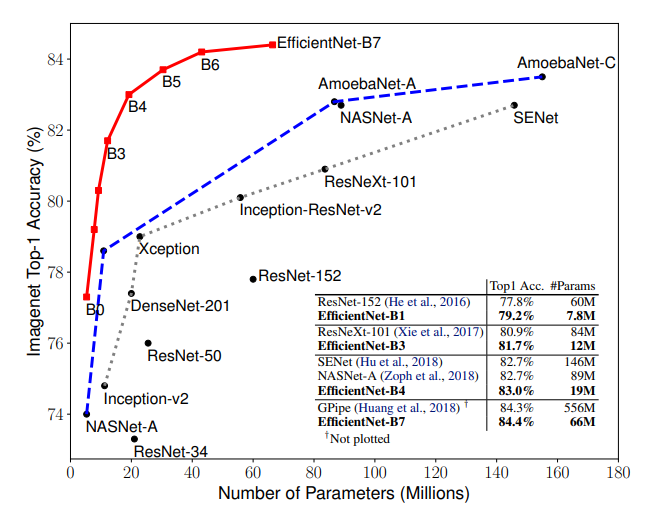

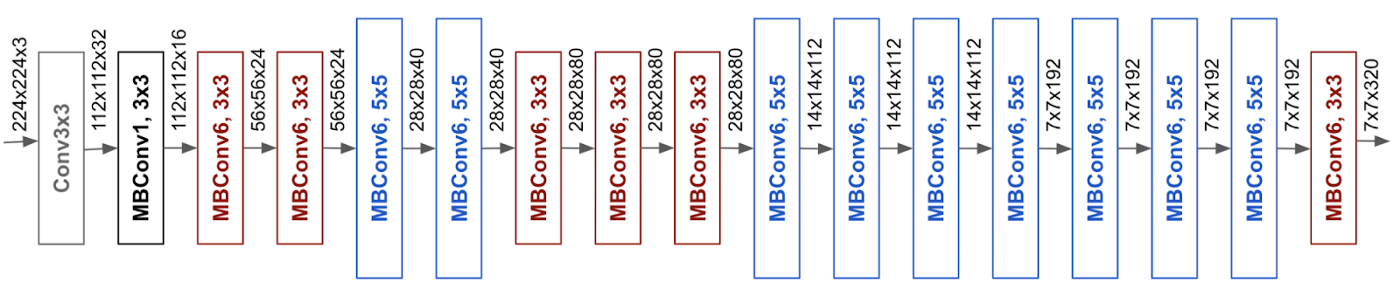
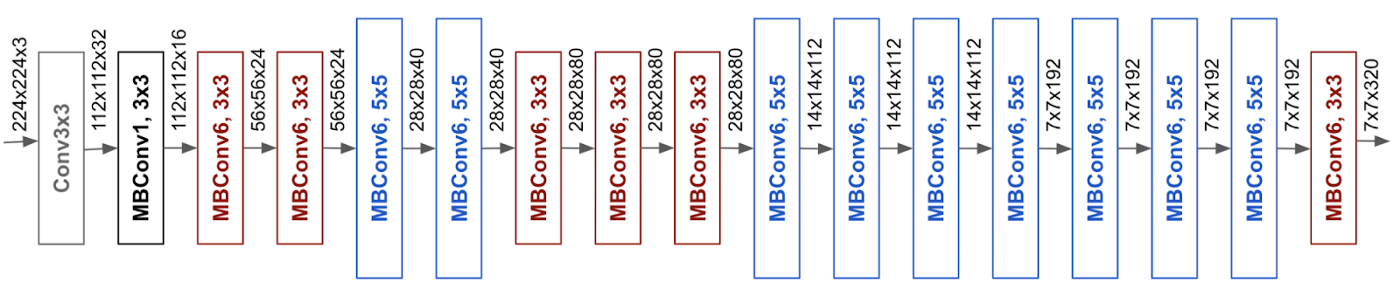

In [8]:
!pip install -U efficientnet
import efficientnet.tfkeras as efn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [9]:
#LEARNING RATE SCHEDULER

def lr_rate(epoch,lr):
    if epoch<5:
        lr=0.00001
        return lr
    elif epoch<=7:
        lr=0.00003
        return lr
    elif epoch<=10:
        lr=0.00001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [10]:
model = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
    ])
    
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])

258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## ENTRENAMIENTO

In [11]:
history=model.fit(train_generator,validation_data= validation_generator,callbacks=[lr_callback],epochs=10,verbose=1)

Epoch 1/10


I0000 00:00:1733526493.235310     151 service.cc:145] XLA service 0x7f5084002910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733526493.235367     151 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733526493.235371     151 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733526747.789396     151 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2446/2446 ━━━━━━━━━━━━━━━━━━━━ 2086s 707ms/step - acc: 0.3651 - loss: 1.4809 - val_acc: 0.5262 - val_loss: 1.1584 - learning_rate: 1.0000e-05
Epoch 2/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 1475s 603ms/step - acc: 0.5236 - loss: 1.1355 - val_acc: 0.5720 - val_loss: 1.0656 - learning_rate: 1.0000e-05
Epoch 3/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 1473s 602ms/step - acc: 0.5804 - loss: 1.0049 - val_acc: 0.5946 - val_loss: 0.9900 - learning_rate: 1.0000e-05
Epoch 4/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 1474s 603ms/step - acc: 0.6195 - loss: 0.9283 - val_acc: 0.6123 - val_loss: 0.9708 - learning_rate: 1.0000e-05
Epoch 5/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 1472s 602ms/step - acc: 0.6550 - loss: 0.8458 - val_acc: 0.6045 - val_loss: 1.0295 - learning_rate: 1.0000e-05
Epoch 6/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 1471s 601ms/step - acc: 0.6605 - loss: 0.8396 - val_acc: 0.6164 - val_loss: 1.0003 - learning_rate: 3.0000e-05
Epoch 7/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 1471s 601ms/step - acc: 0.7174 - loss: 0.7043 - val

## DESEMPEÑO

In [ ]:
results = model.evaluate(test_generator)

In [12]:
def visualization_results(history):
    epochs=[i for i in range(10)]
    fig,ax=plt.subplots(2,1)
    train_acc=history.history['acc']
    train_loss=history.history['loss']
    val_acc=history.history['val_acc']
    val_loss=history.history['val_loss']
    fig.set_size_inches(10,12)
    
    ax[0].plot(epochs, train_acc, 'go-', label='Entrenamiento Accuracy')
    ax[0].plot(epochs, val_acc, 'ro-', label='Validación Accuracy')
    ax[0].set_title('Entrenamiento y Validación Accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].plot(epochs, train_loss, 'go-', label='Entrenamiento Loss')
    ax[1].plot(epochs, val_loss, 'ro-', label='Validación Loss')
    ax[1].set_title('Entrenamiento y Validación Loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    
    plt.show()

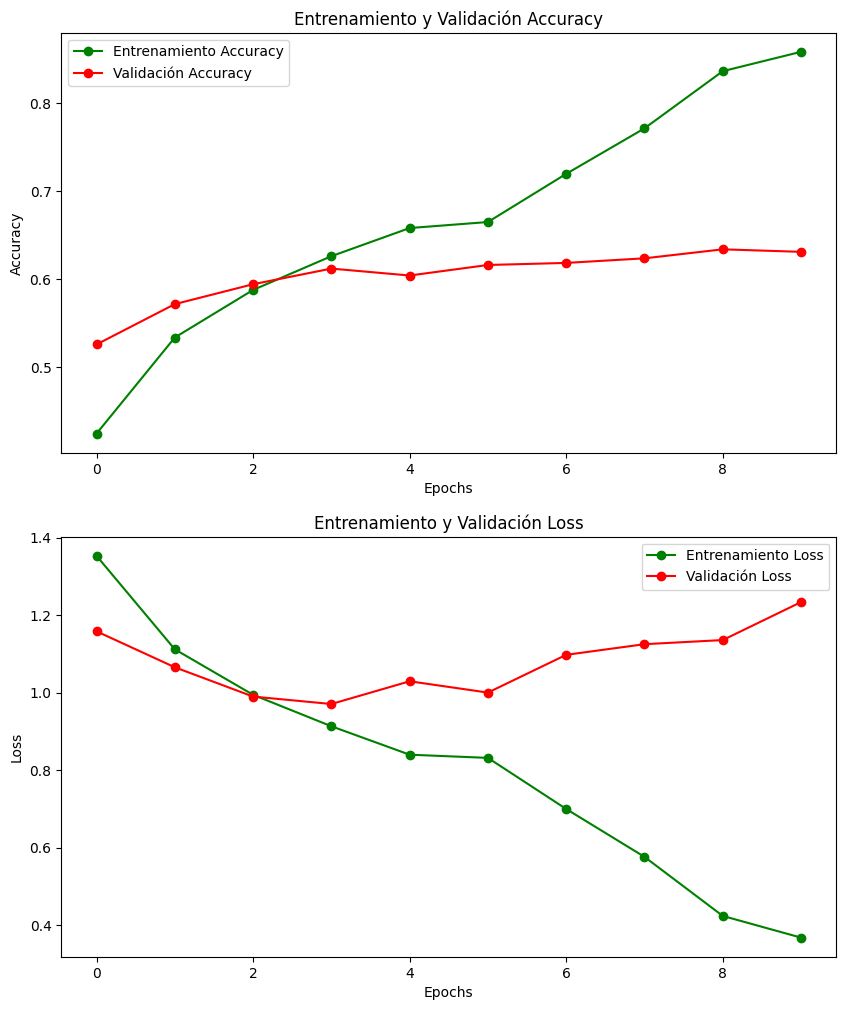

In [13]:
visualization_results(history)

512/512 ━━━━━━━━━━━━━━━━━━━━ 97s 169ms/step


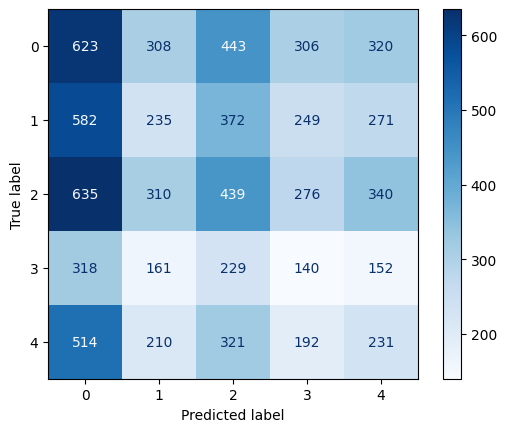

In [14]:
# Obtener predicciones del modelo
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap='Blues')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
# Obtener el reporte de clasificación con precisión, recall, F1-score por clase
report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.23      0.31      0.27      2000
           1       0.19      0.14      0.16      1709
           2       0.24      0.22      0.23      2000
           3       0.12      0.14      0.13      1000
           4       0.18      0.16      0.17      1468

    accuracy                           0.20      8177
   macro avg       0.19      0.19      0.19      8177
weighted avg       0.20      0.20      0.20      8177



## GUARDAR

In [ ]:
!pip install pyyaml h5py
model.save('best_model.h5')

In [ ]:
# Cargamos el modelo
new_model = tf.keras.models.load_model('best_model.h5')